# Prepare dollar street dataset for deep learning

In [1]:
from PIL import Image
import pandas as pd
import pathlib
import numpy as np
import matplotlib.pyplot as plt

## Load data
Download the data from https://www.kaggle.com/datasets/mlcommons/the-dollar-street-dataset. Note that it is 101GB!

In [2]:
DATA_FOLDER = pathlib.Path('../data/dataset_dollarstreet/') # change to location where you stored the data

### Show example image

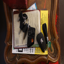

In [4]:
example_filepath = DATA_FOLDER / 'assets/5d4bde20cf0b3a0f3f3359fb/5d4bde20cf0b3a0f3f3359fb.jpg'
image = Image.open(example_filepath)
image = image.resize((64, 64))
display(image)

## Prepare labels
1. Only take examples with one imagenet_synonym label
2. Use only examples with the 10 most frequently occuring labels

In [5]:
df = pd.read_csv(DATA_FOLDER / 'images_v2_imagenet_test.csv', converters={'imagenet_synonyms': eval})

In [6]:
# Take only rows where we have one label (to simplify the problem to multiclass not multilabel classification)
df_selection = df[df['imagenet_synonyms'].apply(len) == 1]

In [7]:
len(df)

4308

In [8]:
len(df_selection)

3772

In [9]:
df_selection['label'] = df_selection['imagenet_synonyms'].apply(lambda x: x[0])

/var/folders/ff/lzvrl_f53bl3fwlbvnsw4f840000gn/T/ipykernel_58901/1875909903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selection['label'] = df_selection['imagenet_synonyms'].apply(lambda x: x[0])


In [10]:
df_10 = df_selection[df_selection['label'].isin(df_selection['label'].value_counts()[:10].index)]

## Prepare images
1. Downscale to 64 x 64 pixels
2. Store as numpy array

In [11]:
images_matrix = np.zeros((len(df_10), 64, 64, 3), dtype='int32')
for i, (_, row) in enumerate(df_10[['label', 'imageRelPath']].iterrows()):
    filepath = DATA_FOLDER / row['imageRelPath']
    image = Image.open(filepath)
    image = image.resize((64, 64))
    data = np.array(image, dtype='int32')
    images_matrix[i, :, :, :] = data

## Prepare data for training

In [12]:
from sklearn.model_selection import train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(
    images_matrix, df_10['label'].reset_index(drop=True), stratify=df_10['label'])

In [13]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder().fit(train_labels)
train_labels = encoder.transform(train_labels)
val_labels = encoder.transform(val_labels)

In [14]:
pd.DataFrame({'label': encoder.classes_, 'index': encoder.transform(encoder.classes_)})

,label,index
0,day bed,0
1,dishrag,1
2,plate,2
3,running shoe,3
4,soap dispenser,4
5,street sign,5
6,table lamp,6
7,tile roof,7
8,toilet seat,8
9,washing machine,9


## Save data

In [15]:
np.save(DATA_FOLDER / 'train_images.npy', train_images)
np.save(DATA_FOLDER / 'test_images.npy', val_images)
np.save(DATA_FOLDER / 'train_labels.npy', train_labels)
np.save(DATA_FOLDER / 'test_labels.npy', val_labels)